In [4]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix  
import os
from torch import nn
import os
import pandas as pd
import cv2 
import torch
from tqdm import tqdm

In [5]:
def IoU_coeff(y_true, y_pred):
    axes = (0,1)
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) 
    mask = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask - intersection
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    return iou

### Not used

In [15]:
# def compute_iou(y_true, y_pred):
#     # ytrue, ypred is a flatten vector
#     y_pred = y_pred.flatten()
#     y_true = y_true.flatten()
#     current = confusion_matrix(y_true, y_pred, labels=[0, 1])
#     # compute mean iou
#     intersection = np.diag(current)
#     ground_truth_set = current.sum(axis=1)
#     predicted_set = current.sum(axis=0)
#     union = ground_truth_set + predicted_set - intersection
#     IoU = intersection / union.astype(np.float32)
#     return np.mean(IoU)

In [19]:
def load_and_get_iou(img_name, original_mask ,model, feature_extractor, show_img = False, img_dir = "/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person_occluded/occluded_dataset/a=0.005/", mask_dir = "../people_segmentation/original/masks", pred_mask_dir = "../people_segmentation/original/pred_masks", threshold = 0.02, save_mask=True):
    image = Image.open(f'{img_dir}/{img_name}.jpg')
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    upsampled_logits = nn.functional.interpolate(logits,
                    size=image.size[::-1], # (height, width)
                    mode='bilinear',
                    align_corners=False)
    pred_mask = upsampled_logits.argmax(dim=1)[0] == 12
    pred_mask = pred_mask.cpu().detach().numpy().astype(int)
    original_mask = original_mask
    
    if show_img==True:
        plt.subplot(1,3,1)
        plt.imshow(original_mask[:,:,0], cmap="gray")
        plt.subplot(1,3,2)
        plt.imshow(pred_mask, cmap = "gray")
        plt.subplot(1,3,3)
        plt.imshow(image)
    if save_mask:
        # save predicted mask
        plt.imsave(f"{pred_mask_dir}/{img_name}.png", pred_mask, cmap='gray')
    return IoU_coeff(original_mask[:,:,0], pred_mask)

## Segformer B0 Model

In [5]:
feature_extractor_b0 = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model_b0 = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

NameError: name 'SegformerFeatureExtractor' is not defined

0.9161156796859004

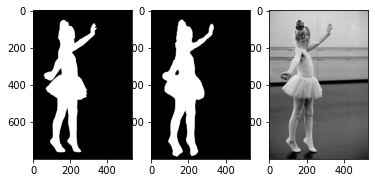

In [22]:
load_and_get_iou("young-girl-ballerina-dance-591679", model = model_b0,feature_extractor=feature_extractor_b0, show_img = True)

## Segformer B4 Model

In [16]:
feature_extractor_b4 = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
model_b4 = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")


0.9779987077583546

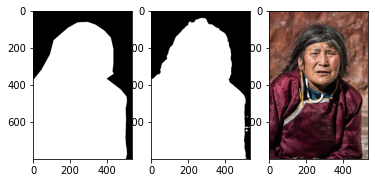

In [27]:
load_and_get_iou("woman-tibet-indigenous-39029", model = model_b4,feature_extractor=feature_extractor_b4, show_img = True)

In [200]:
all_iou_b0 = []

for root, dirs, files in os.walk("./people_segmentation/images/", topdown=False):
    for img_name in files:
        all_iou_b0.append(load_and_get_iou(img_name[:-4]))


## Segformer B5 Model

In [6]:
feature_extractor_b5 = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
model_b5 = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")

## Apply to whole dataset

### Original Dataset

# On the occluded data

In [9]:
##defining the paths
occ_data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person_occluded/occluded_dataset/'
data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person/people_segmentation/'

Img_folders = ['a=0.005', 
           'a=0.01',
           'a=0.05',
           'a=0.1',
           'a=0.5',
            'a=1']
Prediction_folders = [
           'predictions_a=0.005_ViT', 
           'predictions_a=0.01_ViT',
           'predictions_a=0.05_ViT',
           'predictions_a=0.1_ViT',
           'predictions_a=0.5_ViT',
            'predictions_a=1_ViT']


In [16]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_b5.to(device)

iou_dict = {Img_folders[0]:{},
            Img_folders[1]:{},
            Img_folders[2]:{},
            Img_folders[3]:{},
            Img_folders[4]:{},
            Img_folders[5]:{}
           }
for folder_idx in range(len(Img_folders)):
    ## creating the directories
    Images_dir = os.path.join(occ_data_path, Img_folders[folder_idx])
    Masks_dir = os.path.join(data_path, 'masks')
    Predictions_dir = os.path.join(occ_data_path, Prediction_folders[folder_idx])
    Images_list = sorted(os.listdir(Images_dir)) ## getting the list of images inside the directory
    Masks_list = sorted(os.listdir(Masks_dir))  ## getting the list of masks inside the directory
    print(f"----------Testing the dataset {Img_folders[folder_idx]}, predictions stored in {Prediction_folders[folder_idx]}------")
    i = 1
    iou = 0
    
    if not(os.path.exists(Predictions_dir)):
        os.mkdir(Predictions_dir)

    for (img_name, mask_name, k) in zip(Images_list, Masks_list,tqdm(range(len(Images_list)),desc = 'tqdm() Progress Bar')):
        img_dir = os.path.join(Images_dir, f"{img_name}")
        image = cv2.imread(img_dir)
        inputs = feature_extractor_b5(images=image, return_tensors="pt").to(device)
        outputs = model_b5(**inputs)
        logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
        upsampled_logits = nn.functional.interpolate(logits,
                        size=image.shape[0:2], # (height, width)
                        mode='bilinear',
                        align_corners=False)
        pred_mask = upsampled_logits.argmax(dim=1)[0] == 12
        pred_mask = pred_mask.cpu().detach().numpy().astype(int)
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), pred_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, pred_mask)
        iou += iou_img
        iou_dict[Img_folders[folder_idx]][img_name] = iou_img

        
    print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

#     df = pd.DataFrame.from_dict({"name":iou_original.keys(),"iou": iou_original.values()})
    # df.to_csv("../people_segmentation/original/iou.csv")

cuda:0
----------Testing the dataset a=0.005, predictions stored in predictions_a=0.005_ViT------


tqdm() Progress Bar: 100%|█████████████████▉| 5677/5678 [19:56<00:00,  4.74it/s]


The average IoU score for this testset is 0.8360177563475143
----------Testing the dataset a=0.01, predictions stored in predictions_a=0.01_ViT------


tqdm() Progress Bar: 100%|█████████████████▉| 5677/5678 [20:54<00:00,  4.53it/s]


The average IoU score for this testset is 0.8278032977737577
----------Testing the dataset a=0.05, predictions stored in predictions_a=0.05_ViT------


tqdm() Progress Bar: 100%|█████████████████▉| 5677/5678 [21:43<00:00,  4.36it/s]


The average IoU score for this testset is 0.8138977575872526
----------Testing the dataset a=0.1, predictions stored in predictions_a=0.1_ViT------


tqdm() Progress Bar: 100%|█████████████████▉| 5677/5678 [20:45<00:00,  4.56it/s]


The average IoU score for this testset is 0.781136887640768
----------Testing the dataset a=0.5, predictions stored in predictions_a=0.5_ViT------


tqdm() Progress Bar: 100%|█████████████████▉| 5677/5678 [18:41<00:00,  5.06it/s]


The average IoU score for this testset is 0.30016319220767745
----------Testing the dataset a=1, predictions stored in predictions_a=1_ViT------


tqdm() Progress Bar: 100%|█████████████████▉| 5677/5678 [18:11<00:00,  5.20it/s]

The average IoU score for this testset is 0.08313776001062556


In [13]:
from tqdm import tqdm

In [20]:
##defining the folders
data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person shuffled/'
Img_folders = ['Images_grid=2', 
               'Images_grid=4',
               'Images_grid=8',
               'Images_grid=16',
               'Images_grid=32'
           ]
Masks_folders = ['Masks_grid=2', 
           'Masks_grid=4',
           'Masks_grid=8',
           'Masks_grid=16',
           'Masks_grid=32'
                ]
Prediction_folders = ['Predictions_grid=2_ViT', 
                       'Predictions_grid=4_ViT',
                       'Predictions_grid=8_ViT',
                       'Predictions_grid=16_ViT',
                       'Predictions_grid=32_ViT']

In [21]:
## Iterating over the images and predicting the masks, then then storing them in a pridictions folder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_b5.to(device)

iou_dict_shuffeling = {Img_folders[0]:{},
            Img_folders[1]:{},
            Img_folders[2]:{},
            Img_folders[3]:{},
            Img_folders[4]:{}
           }
for folder_idx in range(len(Img_folders)):
    ## creating the directories
    Images_dir = os.path.join(data_path, Img_folders[folder_idx])
    Masks_dir = os.path.join(data_path, Masks_folders[folder_idx])
    Predictions_dir = os.path.join(data_path, Prediction_folders[folder_idx])
    Images_list = sorted(os.listdir(Images_dir)) ## getting the list of images inside the directory
    Masks_list = sorted(os.listdir(Masks_dir))  ## getting the list of masks inside the directory
    print(f"----------Testing the dataset {Img_folders[folder_idx]}, predictions stored in {Prediction_folders[folder_idx]}------")
    i = 1
    iou = 0
    
    if not(os.path.exists(Predictions_dir)):
        os.mkdir(Predictions_dir)

    for (img_name, mask_name, k) in zip(Images_list, Masks_list,tqdm(range(len(Images_list)),desc = f"Progress for {Img_folders[folder_idx]}")):
        img_dir = os.path.join(Images_dir, f"{img_name}")
        image = cv2.imread(img_dir)
        inputs = feature_extractor_b5(images=image, return_tensors="pt").to(device)
        outputs = model_b5(**inputs)
        logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
        upsampled_logits = nn.functional.interpolate(logits,
                        size=image.shape[0:2], # (height, width)
                        mode='bilinear',
                        align_corners=False)
        pred_mask = upsampled_logits.argmax(dim=1)[0] == 12
        pred_mask = pred_mask.cpu().detach().numpy().astype(int)
        ##saving the predicted mask
        cv2.imwrite(os.path.join(Predictions_dir, mask_name), pred_mask)
        ##getting the ground truth 
        mask_dir = os.path.join(Masks_dir, mask_name)
        ground_truth = cv2.imread(mask_dir, 0)
        ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
        ## computing the IoU score
        iou_img = IoU_coeff(ground_truth, pred_mask)
        iou += iou_img
        iou_dict_shuffeling[Img_folders[folder_idx]][img_name] = iou_img

        
    print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

#     df = pd.DataFrame.from_dict({"name":iou_original.keys(),"iou": iou_original.values()})
    # df.to_csv("../people_segmentation/original/iou.csv")

cuda:0
----------Testing the dataset Images_grid=2, predictions stored in Predictions_grid=2_ViT------


Progress for Images_grid=2: 100%|██████████▉| 5677/5678 [13:12<00:00,  7.16it/s]


The average IoU score for this testset is 0.7440998800059971
----------Testing the dataset Images_grid=4, predictions stored in Predictions_grid=4_ViT------


Progress for Images_grid=4: 100%|██████████▉| 5677/5678 [13:12<00:00,  7.16it/s]


The average IoU score for this testset is 0.5413235219761716
----------Testing the dataset Images_grid=8, predictions stored in Predictions_grid=8_ViT------


Progress for Images_grid=8: 100%|██████████▉| 5677/5678 [13:07<00:00,  7.21it/s]


The average IoU score for this testset is 0.17345149305514707
----------Testing the dataset Images_grid=16, predictions stored in Predictions_grid=16_ViT------


Progress for Images_grid=16: 100%|█████████▉| 5677/5678 [13:32<00:00,  6.99it/s]


The average IoU score for this testset is 0.013203855710736312
----------Testing the dataset Images_grid=32, predictions stored in Predictions_grid=32_ViT------


Progress for Images_grid=32: 100%|█████████▉| 5677/5678 [13:46<00:00,  6.87it/s]

The average IoU score for this testset is 0.0006749092561604218


# testing on the stylized data

cuda:0


Progress: 100%|████████████████████████████▉| 5677/5678 [26:53<00:00,  3.52it/s]


The average IoU score for this testset is 0.12539823615218718


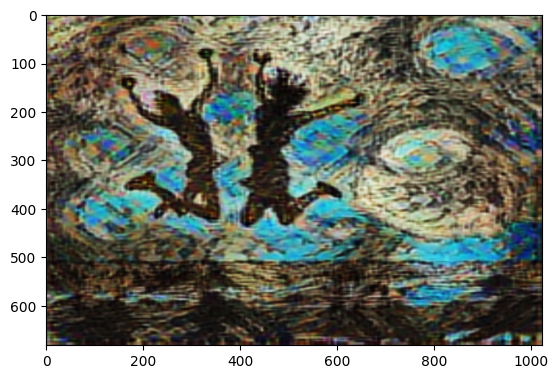

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_b5.to(device)

## path to store the shuffled images and shuffled masks
stylized_data_path  ='/home/mohamed.boudjoghra/assignements/AI701/project/datasets/person_stylized'
stylized_Images_dir = os.path.join(stylized_data_path, 'images')
stylized_Masks_dir = os.path.join(stylized_data_path, 'masks')

Predictions_dir = os.path.join(stylized_data_path, 'predctions')
Images_list = sorted(os.listdir(stylized_Images_dir)) ## getting the list of images inside the directory
Masks_list = sorted(os.listdir(stylized_Masks_dir))  ## getting the list of masks inside the directory

iou = 0

if not(os.path.exists(Predictions_dir)):
    os.mkdir(Predictions_dir)

for (img_name, mask_name, k) in zip(Images_list, Masks_list,tqdm(range(len(Images_list)),desc = f"Progress")):
    Image_dir = os.path.join(stylized_Images_dir, f"{img_name}")
    image = plt.imread(Image_dir)
    plt.imshow(image)
    inputs = feature_extractor_b5(images=image, return_tensors="pt").to(device)
    outputs = model_b5(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    upsampled_logits = nn.functional.interpolate(logits,
                    size=image.shape[0:2], # (height, width)
                    mode='bilinear',
                    align_corners=False)
    pred_mask = upsampled_logits.argmax(dim=1)[0] == 12
    pred_mask = pred_mask.cpu().detach().numpy().astype(int)
    ##saving the predicted mask
    cv2.imwrite(os.path.join(Predictions_dir, mask_name), pred_mask)
    ##getting the ground truth 
    mask_dir = os.path.join(stylized_Masks_dir, mask_name)
    ground_truth = cv2.imread(mask_dir, 0)
    ground_truth = np.float64(ground_truth)*(1.0/np.amax(ground_truth))
    ## computing the IoU score
    iou_img = IoU_coeff(ground_truth, pred_mask)
    iou += iou_img


print(f"The average IoU score for this testset is {iou/len(Images_list)}") 

In [6]:
a = np.array([[3,1,1,2], [0,1,1,0], [0,1,1,0],[0,1,1,0]])
a = (a==1)*a

In [2]:
import numpy as np

In [7]:
a

array([[0, 1, 1, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0],
       [0, 1, 1, 0]])